In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Set root paths
dataset_root = "/content/drive/MyDrive/document-forgery-detection/my_dataset"
models_dir = "/content/drive/MyDrive/document-forgery-detection/models"
print("✅ Drive mounted.")
print("Dataset Root:", dataset_root)
print("Models Folder:", models_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted.
Dataset Root: /content/drive/MyDrive/document-forgery-detection/my_dataset
Models Folder: /content/drive/MyDrive/document-forgery-detection/models


In [2]:
import os

print("Dataset folders:", os.listdir(dataset_root))

png_files = [f for f in os.listdir(os.path.join(dataset_root, "val")) if f.endswith(".png")]
txt_files = [f for f in os.listdir(os.path.join(dataset_root, "val")) if f.endswith(".txt")]
print(f"VAL contains: {len(png_files)} PNG images and {len(txt_files)} TXT files")


Dataset folders: ['test.txt', 'train.txt', 'val.txt', 'train', 'val', 'test', 'train.csv', 'val.csv', 'test.csv', 'train_debug.csv', 'val_debug.csv', 'app.py', 'train_filtered.csv', 'val_filtered.csv', 'test_filtered.csv', 'models']
VAL contains: 192 PNG images and 192 TXT files


In [3]:
import pandas as pd

def clean_split(split):
    csv_path = os.path.join(dataset_root, f"{split}.csv")
    if not os.path.exists(csv_path):
        print(f"{csv_path} not found, skipping.")
        return

    df = pd.read_csv(csv_path)
    before = len(df)

    if not df['image_path'].iloc[0].startswith(dataset_root):
        df['image_path'] = dataset_root + "/" + df['image_path']

    df = df[df['image_path'].apply(lambda x: os.path.exists(x) and x.lower().endswith(".png"))]

    removed = before - len(df)
    df.to_csv(csv_path, index=False)
    print(f"✅ {split}.csv cleaned: removed {removed} invalid rows, kept {len(df)}.")

for split in ["train", "val", "test"]:
    clean_split(split)


✅ train.csv cleaned: removed 0 invalid rows, kept 577.
✅ val.csv cleaned: removed 0 invalid rows, kept 192.
✅ test.csv cleaned: removed 0 invalid rows, kept 218.


Train samples: 577 | Val samples: 192


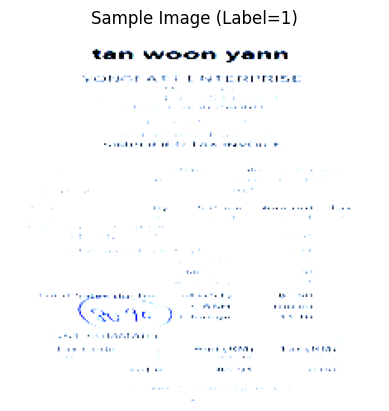

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class ReceiptDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = ReceiptDataset(os.path.join(dataset_root, "train.csv"), transform=transform)
val_dataset = ReceiptDataset(os.path.join(dataset_root, "val.csv"), transform=transform)

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

img, label = train_dataset[0]
plt.imshow(img.permute(1,2,0))
plt.title(f"Sample Image (Label={label})")
plt.axis("off")
plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

labels = pd.read_csv(os.path.join(dataset_root, "train.csv"))['label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Build model
model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
best_val_acc = 0.0
best_model_state = None
patience, wait = 3, 0  # early stopping

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for imgs, lbls in progress:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == lbls).sum().item()

        progress.set_postfix(loss=loss.item())

    train_acc = correct / len(train_dataset)

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            val_correct += (outputs.argmax(dim=1) == lbls).sum().item()

    val_acc = val_correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping ")
            break

# Save best weights
os.makedirs(models_dir, exist_ok=True)
if best_model_state:
    torch.save(best_model_state, os.path.join(models_dir, "best_resnet50.pth"))
    print(f"✅ Best model saved at {models_dir}/best_resnet50.pth (Val Acc={best_val_acc:.3f})")
else:
    print("No model was saved ")


Epoch 1/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 1/10 - Train Acc: 0.575, Val Acc: 0.594


Epoch 2/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 2/10 - Train Acc: 0.683, Val Acc: 0.432


Epoch 3/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 3/10 - Train Acc: 0.790, Val Acc: 0.682


Epoch 4/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 4/10 - Train Acc: 0.872, Val Acc: 0.745


Epoch 5/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 5/10 - Train Acc: 0.884, Val Acc: 0.578


Epoch 6/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 6/10 - Train Acc: 0.901, Val Acc: 0.635


Epoch 7/10:   0%|          | 0/37 [00:00<?, ?batch/s]

Epoch 7/10 - Train Acc: 0.925, Val Acc: 0.557
⏹ Early stopping (no improvement).
✅ Best model saved at /content/drive/MyDrive/document-forgery-detection/models/best_resnet50.pth (Val Acc=0.745)


In [6]:

model.load_state_dict(torch.load(os.path.join(models_dir, "best_resnet50.pth")))
model.eval()

correct = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(model.fc.weight.device), labels.to(model.fc.weight.device)
        outputs = model(imgs)
        correct += (outputs.argmax(dim=1) == labels).sum().item()

print(f"✅ Final Validation Accuracy: {correct / len(val_dataset):.3f}")


✅ Final Validation Accuracy: 0.557
